# wellpathpy prototype

## Goal

To build a light package to load well deviations

## Objectives

1. load well deviation in one of <_n_> formats:
    * meta data (header, rkb, dfe, rt)
    * md, incl, azi
    * mE, mN, depth
    * other ?,?,?
2. interpolate survey using one of these methods:
    * minimum curvature method
    * radius of curvature method
    * tangential method
    * other ?
3. calculate dog-leg severity
4. calculate depth references using header data if available: MD, TVD, TVDSS
5. return interpolated deviation in all <_n_> input formats and in all depth references if possible

## Sources of equations:

- [petrowiki](https://petrowiki.org/Calculation_methods_for_directional_survey)
- [Crain's Petrophysical Handbook](https://www.spec2000.net/19-dip13.htm)
- [drillingformulas](http://www.drillingformulas.com)

## software _architecture_

(get input from Jørgen: `jokva`)

- code to `list` (will then also accept `nd.array`)
- data reader (chooses files to accept: `*.csv`, `*.xlsx`)
- guess data types if not provided by user?
- library of interpolation functions
- depth calculation function
- deploy to [pypi](https://pypi.org/)

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/Well_Surveys_Projected_to_TD.csv', skiprows=4, usecols=['MD[m]','Inc[deg]','Azi[deg]', 'Dogleg [deg/30m]'])
df.head()

,MD[m],Inc[deg],Azi[deg],Dogleg [deg/30m]
0,0,0.0,0.00,NaN
1,76.29,0.9,7.19,0.35
2,104.36,0.9,17.20,0.17
3,134,0.9,15.59,0.03
4,162.73,1.1,6.39,0.27


In [3]:
df.drop(df.tail(1).index,inplace=True)
df.dropna(inplace=True)
df.to_csv('./data/deviation.csv', index=False)

In [4]:
def read_deviation(fname):
    """
    Read a deviation file into memory for processing
    
    Args:
        filename
        
    Return:
        pd.DataFrame
        
    """
    return pd.read_csv(fname)


In [5]:
read_deviation('./data/deviation.csv').head()

,MD[m],Inc[deg],Azi[deg],Dogleg [deg/30m]
0,76.29,0.9,7.19,0.35
1,104.36,0.9,17.20,0.17
2,134.00,0.9,15.59,0.03
3,162.73,1.1,6.39,0.27
4,188.60,1.2,6.00,0.12


In [6]:
def get_headers(datum='kb', units='m', elevation=0.):
    """
    Record deviation header information needed for depth reference calculation into DataFrame.
    
    Parameters
    ----------
    datum : str, default 'kb', {'kb', 'dfe', 'rt'}
            'kb' (kellybushing), 'dfe' (drill floor elevation), 'rt' (rotary table)
    units: str, default 'm', {'m', 'ft'}
            'm' (metres), 'ft' (feet)
    elevation: float, default 0., 
            <datum> <elevation> in <units> above mean sea level
    
    Returns
    -------
    DataFrame
        deviation header dictionnary
    """
    dev_header = {}
    dev_header.update({'datum': datum, 'units': units, 'elevation': elevation})
    
    return dev_header

In [7]:
get_headers(datum='kb', units='m', elevation=12)

{'datum': 'kb', 'units': 'm', 'elevation': 12}

In [8]:
def mdtotvd(deviation, method='mincurv'):
    """
    Calculate TVD from given method.
    
    Parameters
    ----------
    deviation: DataFrame in MD, incl, azi
    method: str, default 'tangential', {'tan', 'avtan', 'baltan', 'merc', 'radcurv', 'mincurv'}
            'tan' (tangential method),  'avtan' (average tangential method),
            'baltan' (balanced tangential method), 'merc' (mercury method),
            'radcurv' (radius of curvature method), 'mincurv' (minimum curvature method)
            method definitions: [Crain's Petrophysical Handbook](https://www.spec2000.net/19-dip13.htm)
            
    Returns
    -------
    DataFrame
        deviation survey converted to TVD, easting, northing
        
    To Do
    -----
    implement methods
            
    """
    
    return deviation

Source:  [Crain's Petrophysical Handbook](https://www.spec2000.net/19-dip13.htm)

Definitions:
  - East = easterly displacement (feet or meters) - negative = West
  - HAZ1 = hole azimuth at top of course (degrees)
  - HAZ2 = hole azimuth at bottom of course (degrees)
  - MD1 = measured depth at top of course (feet or meters)
  - MD2 = measured depth at bottom of course (feet or meters)
  - North = northerly displacement (feet or meters) - negative = South
  - TVD = true vertical depth (feet or meters)
  - WD1 = well deviation at top of course (degrees)
  - WD2 = well deviation at bottom of course (degrees)

The minimum curvature method, like the radius of curvature method, takes the space vectors defined by inclination and direction measurements and smoothes these onto the wellbore curve by the use of a ratio factor which is defined by the curvature (dog-leg) of the wellbore section. The method produces a circular arc as does the radius of the curvature. This is not, however, an assumption of the method, but a result of minimizing the total curvature within the physical constraints on a section of wellbore.

      1: DL = Arccos (Cos (WD2 - WD1) - Sin WD1 * Sin WD2 * (1 - Cos (HAZ2 - HAZ1)))
      2: CF = 2 / DL * (Tan (DL / 2)) * 0.017 453
      3: North = SUM ((MD2 - MD1)*((Sin WD1 * Cos HAZ1 + Sin WD2 * Cos HAZ2) / 2) * CF)
      4: East = SUM ((MD2 - MD1) * ((Sin WD1 * Sin HAZ1 + Sin WD2 * Sin HAZ2) / 2) * CF)
      5: TVD = SUM (((MD2 - MD1) * (Cos WD2 + Cos WD1) / 2) * CF)

Where:

  DL = dog leg severity (degrees)
  
  CF = curvature factor (radians)
  
  The term  0.017 453 converts degrees to radians.

In [9]:
dev = read_deviation('./data/deviation.csv')
dev.head()

,MD[m],Inc[deg],Azi[deg],Dogleg [deg/30m]
0,76.29,0.9,7.19,0.35
1,104.36,0.9,17.20,0.17
2,134.00,0.9,15.59,0.03
3,162.73,1.1,6.39,0.27
4,188.60,1.2,6.00,0.12


In [10]:
dev['Inc[rad]'] = np.radians(dev['Inc[deg]'].values)
dev['Azi[rad]'] = np.radians(dev['Azi[deg]'].values)
dev.head()

,MD[m],Inc[deg],Azi[deg],Dogleg [deg/30m],Inc[rad],Azi[rad]
0,76.29,0.9,7.19,0.35,0.015708,0.125489
1,104.36,0.9,17.20,0.17,0.015708,0.300197
2,134.00,0.9,15.59,0.03,0.015708,0.272097
3,162.73,1.1,6.39,0.27,0.019199,0.111527
4,188.60,1.2,6.00,0.12,0.020944,0.104720


In [11]:
dev_diff = dev.diff()

In [12]:
dev_diff.head()

,MD[m],Inc[deg],Azi[deg],Dogleg [deg/30m],Inc[rad],Azi[rad]
0,NaN,NaN,NaN,NaN,NaN,NaN
1,28.07,0.0,10.01,-0.18,0.000000,0.174707
2,29.64,0.0,-1.61,-0.14,0.000000,-0.028100
3,28.73,0.2,-9.20,0.24,0.003491,-0.160570
4,25.87,0.1,-0.39,-0.15,0.001745,-0.006807


In [13]:
dev_diff.rename(index=str, columns={'MD[m]': 'delta_MD[m]',
                                    'Inc[deg]': 'delta_Inc[deg]',
                                    'Azi[deg]': 'delta_Azi[deg]',
                                    'Inc[rad]': 'delta_Inc[rad]',
                                    'Azi[rad]': 'delta_Azi[rad]',
                                    'Dogleg [deg/30m]': 'delta_Dogleg [deg/30m]',
                                   },
                inplace=True,
               )

In [14]:
dev.reset_index(drop=True, inplace=True)
dev_diff.reset_index(drop=True, inplace=True)

In [15]:
dev = pd.concat([dev, dev_diff], axis=1, join_axes=[dev_diff.index])
dev.head()

,MD[m],Inc[deg],Azi[deg],Dogleg [deg/30m],Inc[rad],Azi[rad],delta_MD[m],delta_Inc[deg],delta_Azi[deg],delta_Dogleg [deg/30m],delta_Inc[rad],delta_Azi[rad]
0,76.29,0.9,7.19,0.35,0.015708,0.125489,NaN,NaN,NaN,NaN,NaN,NaN
1,104.36,0.9,17.20,0.17,0.015708,0.300197,28.07,0.0,10.01,-0.18,0.000000,0.174707
2,134.00,0.9,15.59,0.03,0.015708,0.272097,29.64,0.0,-1.61,-0.14,0.000000,-0.028100
3,162.73,1.1,6.39,0.27,0.019199,0.111527,28.73,0.2,-9.20,0.24,0.003491,-0.160570
4,188.60,1.2,6.00,0.12,0.020944,0.104720,25.87,0.1,-0.39,-0.15,0.001745,-0.006807


DL = Arccos (Cos (WD2 - WD1) - Sin WD1 * Sin WD2 * (1 - Cos (HAZ2 - HAZ1)))

In [16]:
cos_incl = np.cos(dev['delta_Inc[rad]'].values[1:])

In [17]:
incl_uppers = dev['Inc[rad]'].values[:-1]
incl_lowers = dev['Inc[rad]'].values[1:]

In [18]:
sin_incl_product = np.sin(incl_uppers) * np.sin(incl_lowers)

In [19]:
az_uppers = dev['Azi[rad]'].values[:-1]
az_lowers = dev['Azi[rad]'].values[1:]

In [20]:
cos_azi_diff = 1 - np.cos(az_lowers - az_uppers)

In [21]:
cos_incl.shape, sin_incl_product.shape, cos_azi_diff.shape

((78,), (78,), (78,))

In [22]:
dl_temp = np.degrees(np.arccos(cos_incl - sin_incl_product * (cos_azi_diff)))

In [23]:
dev['DL'] = np.insert(dl_temp, 0, np.nan)
dev.head()

,MD[m],Inc[deg],Azi[deg],Dogleg [deg/30m],Inc[rad],Azi[rad],delta_MD[m],delta_Inc[deg],delta_Azi[deg],delta_Dogleg [deg/30m],delta_Inc[rad],delta_Azi[rad],DL
0,76.29,0.9,7.19,0.35,0.015708,0.125489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104.36,0.9,17.20,0.17,0.015708,0.300197,28.07,0.0,10.01,-0.18,0.000000,0.174707,0.157030
2,134.00,0.9,15.59,0.03,0.015708,0.272097,29.64,0.0,-1.61,-0.14,0.000000,-0.028100,0.025288
3,162.73,1.1,6.39,0.27,0.019199,0.111527,28.73,0.2,-9.20,0.24,0.003491,-0.160570,0.255866
4,188.60,1.2,6.00,0.12,0.020944,0.104720,25.87,0.1,-0.39,-0.15,0.001745,-0.006807,0.100305


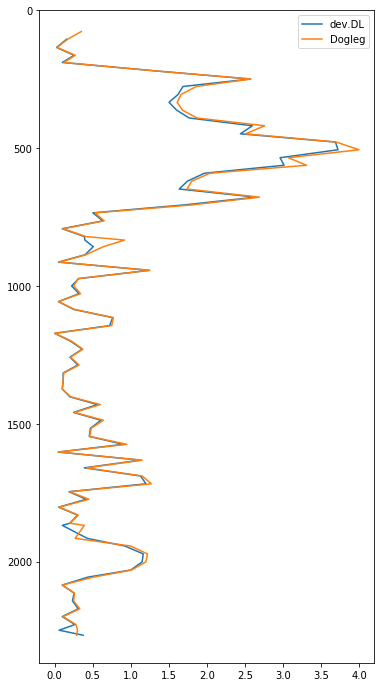

In [26]:
fig, ax = plt.subplots(figsize=(6,12), nrows=1, ncols=1)

ax.plot(dev.DL, dev['MD[m]'])
ax.plot(dev['Dogleg [deg/30m]'], dev['MD[m]'])
ax.set_ylim(dev['MD[m]'].values.max() + 100, 0)
labels = ['dev.DL', 'Dogleg']
plt.legend(labels)

plt.show()